# Intro

## Why Was Chilean National Plebiscite in 1988 Important?
In 1988, Chile held a national plebiscite to decide if Augusto Pinochet should become president 
<br>
for eight years under resumed civilian rule. The "No" side won with 56% of the vote, ending Pinochet's 
<br>
16 and a half year rule. 
<br>
<br>
Democratic elections were held in 1989, leading to the establishment of a 
<br>
new government in 1990


## Questions:
- What are the most important features?
- Did voting intentions differ based on:
    - age
    - sex
    - education
    - income
    - status quo
    - community (population & region)

## Limitations:
- This is a sample taken from before the election
- 2700 voters were surveyed, out of 7,429,404 registered voters

## Data:

chile_voting_intentions_1988.csv contains the following columns:

Categorical:
- vote
    - A, will abstain
    - N, will vote No (against Pinochet)
    - U, undecided
    - Y, will vote yes (for Pinochet)

- region
    - C, Central
    - M, Metropolitan Santiago area
    - N, North
    - S, South
    - SA, city of Santiago.

- sex
    - F, female
    - M, male.

- education (note: out of order)
    - P, Primary
    - PS, Post-secondary
    - S, Secondary

Numeric:

- population
    - Population size of respondent's community.

- age
    - in years.

- income
    - Monthly income, in Pesos.

- statusquo
    - Scale of support for the status-quo. Status quo bias is defined as the preference for maintaining
    <br>
    one's current situation and opposing actions that may change the state of affairs.
    
Additionally, we will refer to population and region as 'community' when talking about them together 

Source: https://rdrr.io/cran/carData/man/Chile.html

# Prepare

### Config tools

In [174]:
# Starting off with importing important tools and reading in the data we will be working with
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

sns.set_palette("rocket", n_colors=5)

### Functions

In [175]:
# Displays a bar plot with scaled variables, used to compare distrubution within groups
def plot_crosstab(col1, col2):
    fig = plt.figure(figsize=(8,5))
    cross_tab_prop = pd.crosstab(index=col1, columns=col2)
    cross_tab_prop.plot(kind='bar', stacked=True)
    plt.legend(loc='upper left')
    plt.axhline(y=0.5, linewidth=3, color='black', linestyle='--', alpha=0.3)
    plt.title(f'{col2.name} by {col1.name}')
    plt.xticks(rotation=0)
    plt.show()

In [176]:
# Used to display the feature importance, can be used for all the models we will be using 
def disp_fi(feature_names, feature_importances):
    plt.figure(figsize=(8,5))
    data = list(zip(feature_names, feature_importances))
    fi = pd.DataFrame(data, columns =['feature', 'importance'])
    
    sns.barplot(data=fi, x='importance', y=feature_names, order=fi.sort_values('importance', ascending=False).feature)
    plt.show()
    return fi

In [177]:
# Performs a chi2 test and prints the statistic and p value with one call. 
def chi_test(col1, col2):
    xt = pd.crosstab(col1, col2)
    chi_result = stats.chi2_contingency(xt)
    return chi_result.statistic, chi_result.pvalue
    

In [178]:
# Creates a new table that we can use for anova tests
def create_anova_frame(df, cat_var, cont_var):
    pivot = df[[cont_var, cat_var]].copy()
    for reg in pivot[cat_var]:
        col1 = pivot.loc[pivot[cat_var]==reg]
        pivot[reg] = col1[cont_var]
        pivot
    pivot = pivot.drop([cont_var,cat_var], axis=1)
    return pivot


## Basic Exploration And Preprocessing

### Overview of data

In [179]:
df = pd.read_csv('chile_voting_intentions_1988.csv')
df.head()

,region,population,sex,age,education,income,statusquo,vote
0,N,175000,M,65.0,P,35000.0,1.00820,Y
1,N,175000,M,29.0,PS,7500.0,-1.29617,N
2,N,175000,F,38.0,P,15000.0,1.23072,Y
3,N,175000,F,49.0,P,35000.0,-1.03163,N
4,N,175000,F,23.0,S,35000.0,-1.10496,N


In [180]:
df.isna().sum()

region          0
population      0
sex             0
age             1
education      11
income         98
statusquo      17
vote          168
dtype: int64

In [181]:
df.loc[df.vote.isna()].head()

,region,population,sex,age,education,income,statusquo,vote
14,N,175000,M,36.0,PS,35000.0,1.49026,NaN
97,N,125000,F,34.0,P,2500.0,0.10807,NaN
112,N,250000,F,46.0,S,NaN,0.15489,NaN
117,N,250000,M,49.0,S,35000.0,-0.30605,NaN
184,N,45000,M,70.0,P,75000.0,0.01309,NaN


We can see a lot of null values for votes and income, we need to make a decision on how to handle these. There are a few options to choose from, remove them or assign them the average value etc. I will remove them here because we will still have many data points 

In [182]:
df = df.dropna()
df.isna().sum()

region        0
population    0
sex           0
age           0
education     0
income        0
statusquo     0
vote          0
dtype: int64

In [183]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2431 entries, 0 to 2699
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   region      2431 non-null   object 
 1   population  2431 non-null   int64  
 2   sex         2431 non-null   object 
 3   age         2431 non-null   float64
 4   education   2431 non-null   object 
 5   income      2431 non-null   float64
 6   statusquo   2431 non-null   float64
 7   vote        2431 non-null   object 
dtypes: float64(3), int64(1), object(4)
memory usage: 170.9+ KB


In [184]:
df.describe()

,population,age,income,statusquo
count,2431.000000,2431.000000,2431.000000,2431.000000
mean,151605.306458,38.290004,34019.950638,-0.011267
std,101876.499290,14.667179,39740.005252,1.004542
min,3750.000000,18.000000,2500.000000,-1.725940
25%,25000.000000,25.000000,7500.000000,-1.009740
50%,175000.000000,36.000000,15000.000000,-0.089240
75%,250000.000000,49.000000,35000.000000,0.969690
max,250000.000000,70.000000,200000.000000,1.713550


### Categorical data

In [185]:
# Reordering educational categories
df.education = pd.Categorical(df.education, ["P", "S", "PS"])
df.education.value_counts()

education
S     1010
P     1002
PS     419
Name: count, dtype: int64

In [186]:
df.sex.value_counts()

sex
F    1250
M    1181
Name: count, dtype: int64

In [187]:
df.region.value_counts()

region
SA    848
S     655
C     548
N     305
M      75
Name: count, dtype: int64

In [188]:
len(df.loc[df.region=='M']) / len(df.loc[df.region=='SA'])

0.08844339622641509

We can see that Metropolitan Santiago is the least represented region, with a ~9% representation compared to the largest group, Santiago, it could cause a class imbalance in our analysis. We need to adjust the ratios to make it more balanced, but with a sample size of <3000 we can't simply disregard the over-represented classes.

In [189]:
# Create an encoded data frame

le = LabelEncoder()
df_enc = df.copy()
df_enc.sex = le.fit_transform(df_enc.sex)
df_enc.region = le.fit_transform(df_enc.region)
df_enc.education = le.fit_transform(df_enc.education)
df_enc.vote = le.fit_transform(df_enc.vote)
df_enc.head()

,region,population,sex,age,education,income,statusquo,vote
0,2,175000,1,65.0,0,35000.0,1.00820,3
1,2,175000,1,29.0,1,7500.0,-1.29617,1
2,2,175000,0,38.0,0,15000.0,1.23072,3
3,2,175000,0,49.0,0,35000.0,-1.03163,1
4,2,175000,0,23.0,2,35000.0,-1.10496,1


## Initial cleaning:
- Missing values in multiple columns, ~200 missing voting intentions. 
    - Fix: drop rows with null values
- Categorical data defined with strings could interfere with future use of models. 
    - Fix: Added data frame with encoded varaibles
- Education column out of order. 
    - Fix: Ordered categries
- The region date could cause issues with class imbalance, which we will address when building the models.

# Overview of Voter Distrubution
We will look for class imbalances and other potential problems with the data

#### Votes

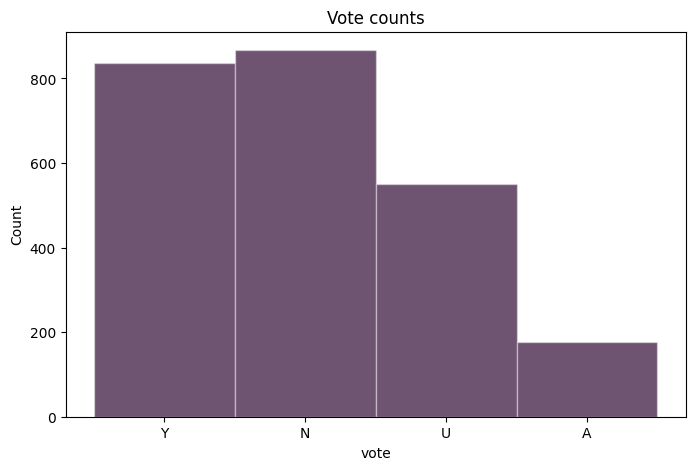

In [190]:
# Get vote distrubution
plt.figure(figsize=(8,5))
sns.histplot(data=df.vote, edgecolor=(1, 1, 1, .4))\
    .set_title('Vote counts')
plt.show()

#### Sexes

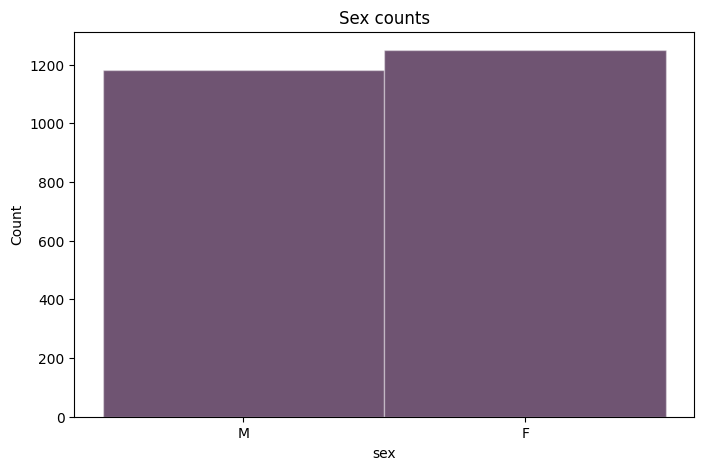

In [191]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.sex, edgecolor=(1, 1, 1, .4))\
    .set_title('Sex counts')
plt.show()

#### Ages

In [192]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.age, edgecolor=(1, 1, 1, .4))\
    .set_title('Age Counts')
plt.show()

#### Education

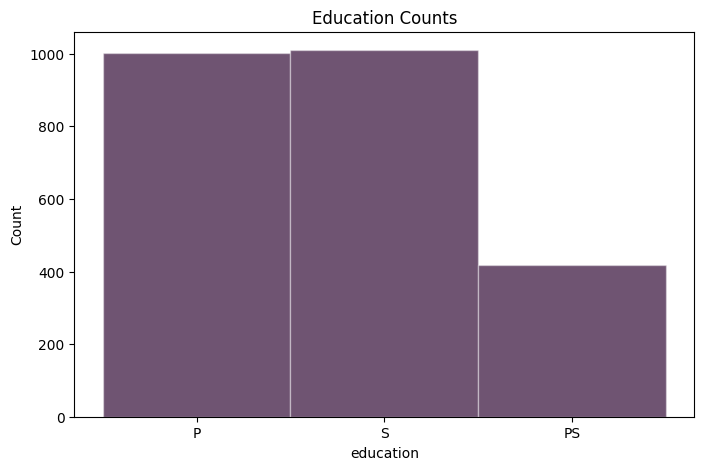

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.sort_values('education').education, edgecolor=(1, 1, 1, .4))\
    .set_title('Education Counts')
plt.show()

#### Region

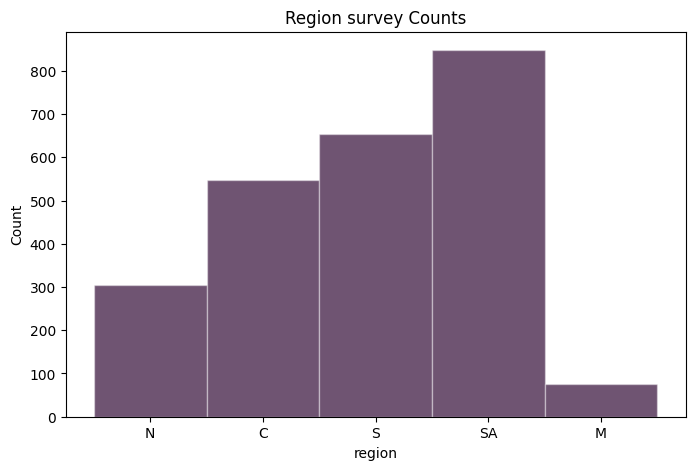

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.histplot(data=df.region, edgecolor=(1, 1, 1, .4))\
    .set_title('Region survey Counts')
plt.show()

#### Income

In [ ]:
df.income.value_counts().sort_index(ascending=True)

income
2500.0      149
7500.0      460
15000.0     719
35000.0     697
75000.0     249
125000.0     85
200000.0     72
Name: count, dtype: int64

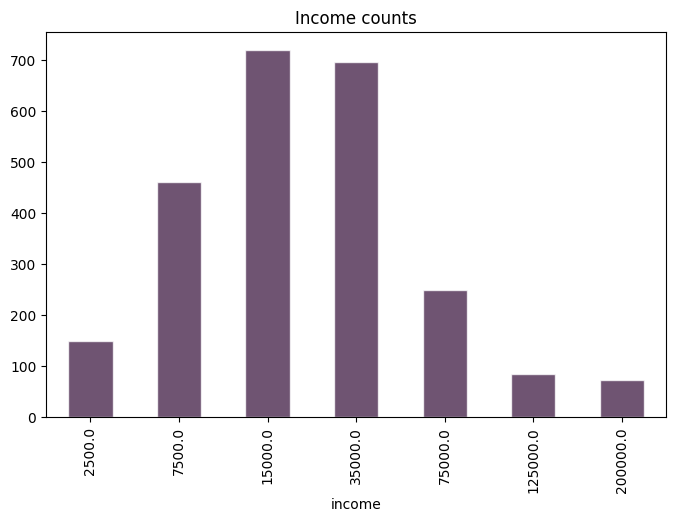

In [ ]:
fig = plt.figure(figsize=(8,5))
dt = df.income.value_counts().sort_index(ascending=True).plot(kind='bar', alpha=.75, edgecolor=(1, 1, 1, .4))\
    .set_title('Income counts')
plt.show()

#### Status Quo

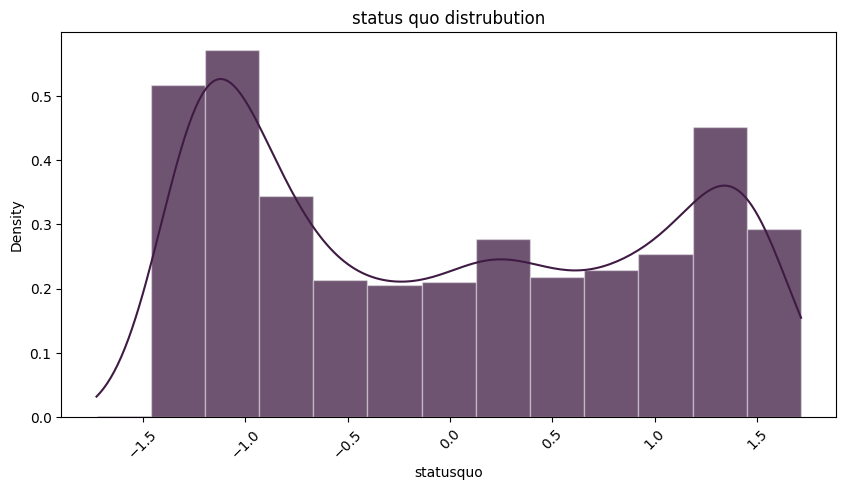

In [ ]:
fig = plt.figure(figsize=(10,5))
sns.histplot(df.statusquo, kde=True,stat="density", alpha=.75, edgecolor=(1, 1, 1, .4))\
    .set_title('status quo distrubution')
plt.xticks(rotation=45)
plt.show()

## Vote Distrubution for All Features

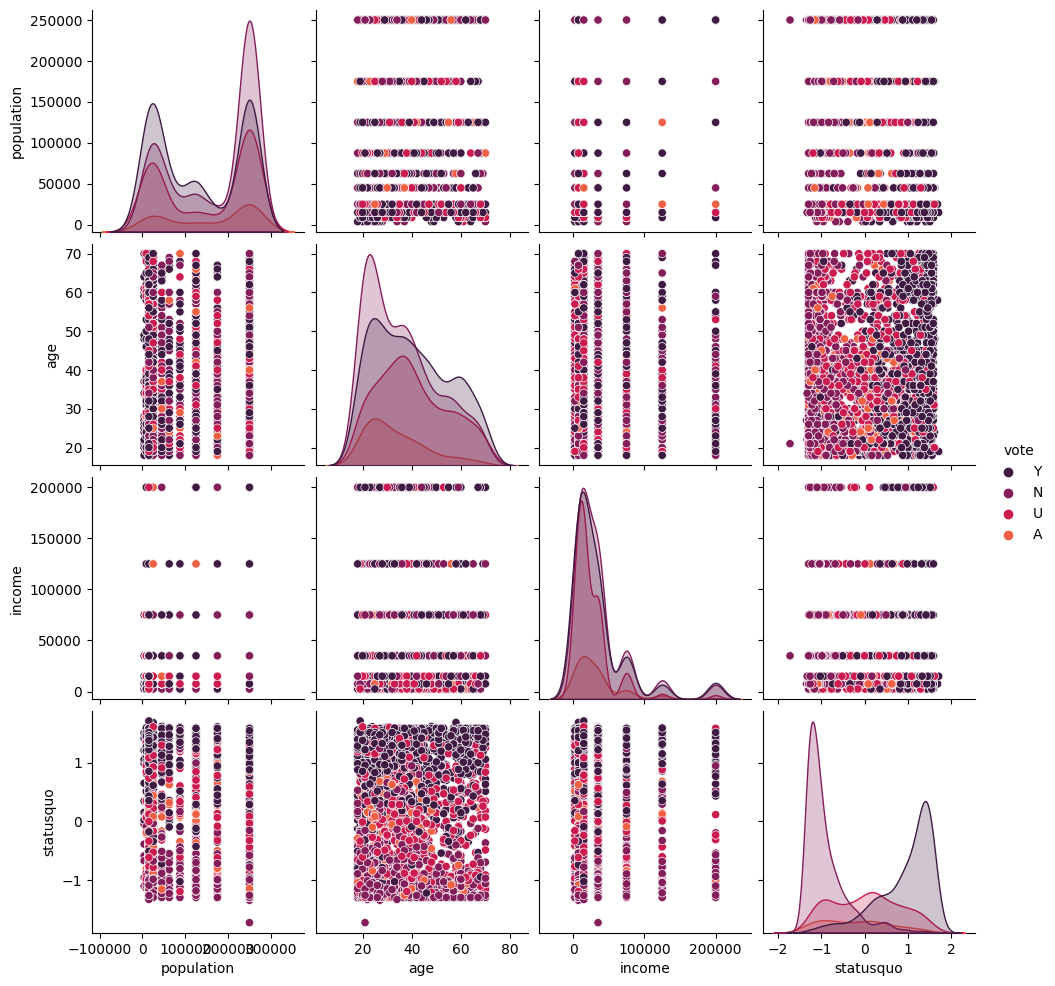

In [ ]:
sns.pairplot(df,hue='vote')

## Relationships of Different Features

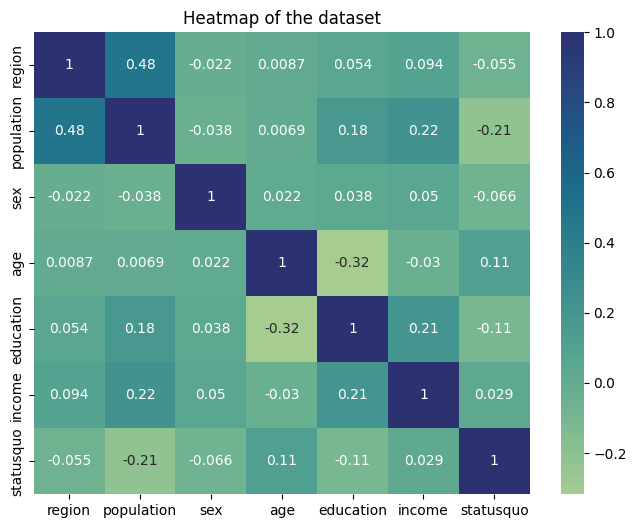

In [ ]:
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc.drop('vote', axis=1).corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

#### Here we can see some relationships with an absolute value greater than 0.1:
Negative:
- Negative relationship between age and status quo -0.11
- Negative relationship between age and education of -0.3
- Negative relationship between population and status quo -0.21

Positive:
- Positive relationship between population and region of 0.48
- Positive relationship between population and education of 0.18
- Positive relationship between income and population of 0.22
- Positive relationship between income and education of 0.21

We will keep these in mind when doing our feature selection.

## Define Features

In [ ]:
# Define the features and target variables for our models
FEATURES = ["region","sex","age","income","statusquo", "population"]
TARGET = ['vote']

In [ ]:
# Assign each data point an age group to make further comparisons
bins = [0, 30, 44, 57, 100]
group_names = ['18-30','31-44','45-57','58-70']
df['age_group'] = pd.cut(df['age'], bins, labels=group_names)

# Statistical Significance of the Vote
We need to determine if our sample size is varied and big enough to declare it statistically significant

## Chi Squared on Voting Results
Null hypothesis: Voter intentions are the same for all choices

Alternative hypothesis: Voter intention is NOT the same across choises

In [ ]:
observed = df.vote.value_counts()

dict = {'Y' : .25,
        'N' : .25,
        'U' : .25,
        'A' : .25}
   
expected = pd.Series(dict)* np.sum(observed)
stats.chisquare(f_obs = observed, f_exp = expected)

Power_divergenceResult(statistic=506.9103249691485, pvalue=1.517334667059817e-109)

The vote is of statistical significance. With a P value lower than 0.05 (5%), we can reject the null hypothesis and accept the alternative.

# Voting distrubution

## Sex by Vote

<Figure size 800x500 with 0 Axes>

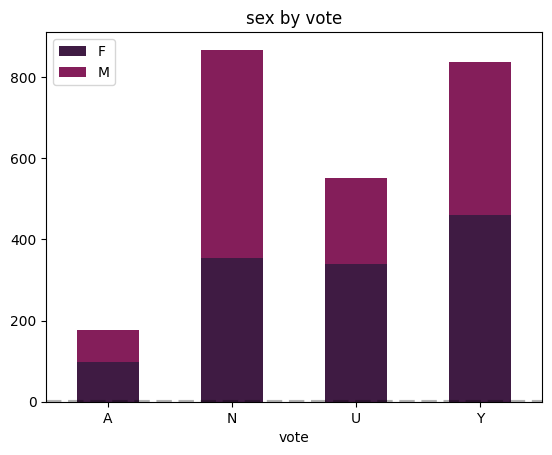

In [ ]:
plot_crosstab(df.vote, df.sex)

In [ ]:
chi_test(df.vote, df.sex)

(65.47257447804787, 3.9743709739554787e-14)

## Education by Vote

<Figure size 800x500 with 0 Axes>

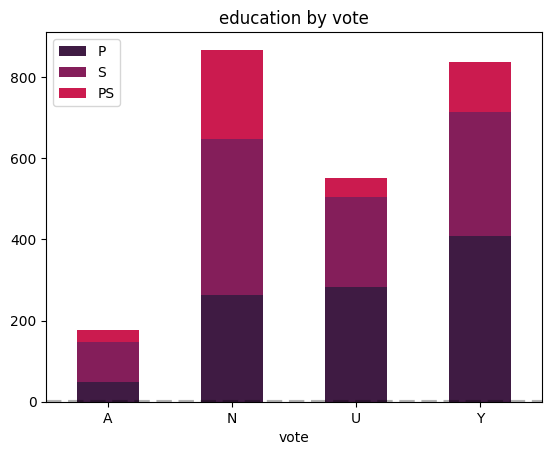

In [ ]:
plot_crosstab(df.vote, df.education)

In [ ]:
chi_test(df.vote, df.education)

(135.69210459331407, 8.121824030596003e-27)

## Age Group by Vote

<Figure size 800x500 with 0 Axes>

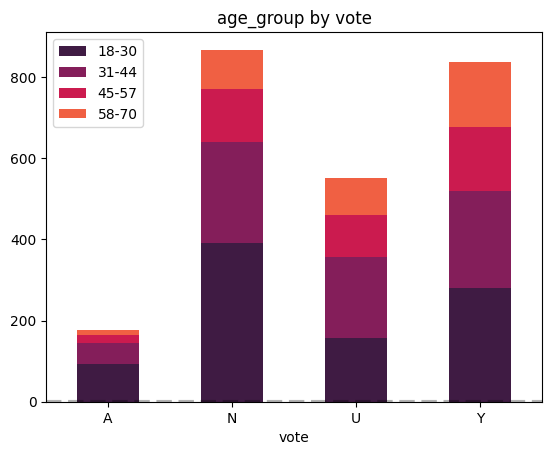

In [ ]:
plot_crosstab(df.vote, df.age_group)

In [ ]:
chi_test(df.vote, df.age_group)

(79.78207123675138, 1.7855023580115547e-13)

## Vote by Income

<Figure size 800x500 with 0 Axes>

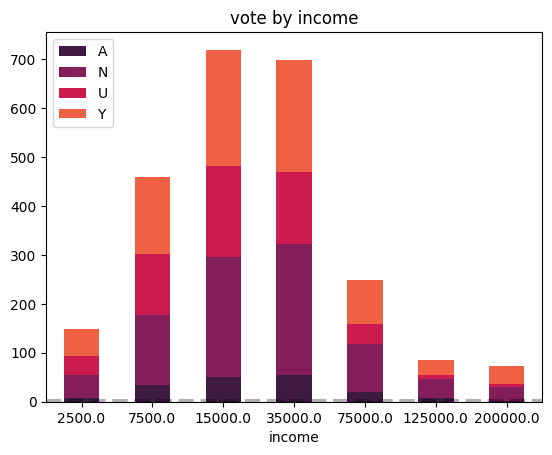

In [ ]:
plot_crosstab(df.income, df.vote)

In [ ]:
chi_test(df.vote, df.income)

(46.20878016195439, 0.00027655950477319634)

## Community and Votes

### Region

<Figure size 800x500 with 0 Axes>

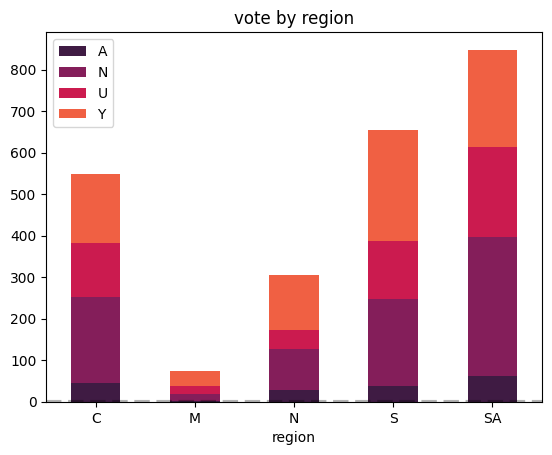

In [ ]:
plot_crosstab(df.region, df.vote)

In [ ]:
chi_test(df.vote, df.region)

(62.95102531730626, 6.506162377659528e-09)

### Population

<Figure size 800x500 with 0 Axes>

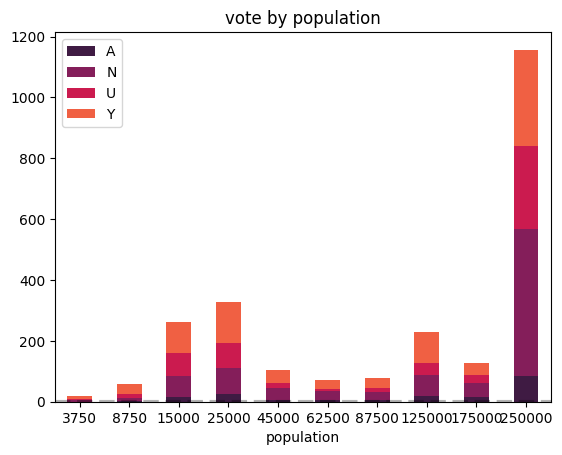

In [ ]:
plot_crosstab(df.population, df.vote)

In [ ]:
pivot = create_anova_frame(df, 'vote', 'population')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=20.68471156589318, pvalue=3.121102203639963e-13)

## Status Quo and Votes

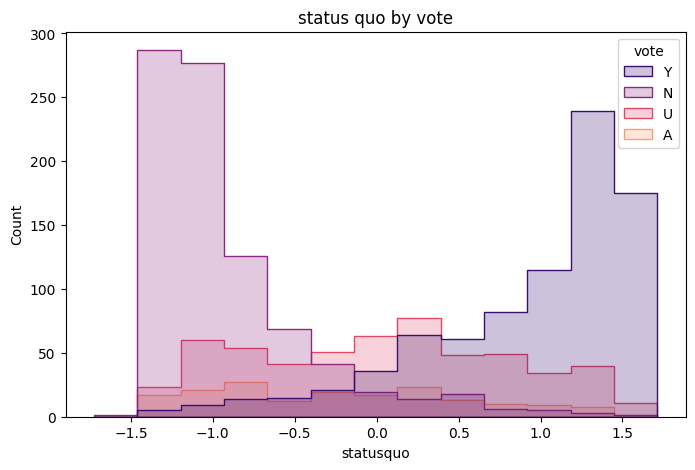

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.histplot(x=df.statusquo, hue=df.vote, element="step", palette="magma")\
    .set_title('status quo by vote')
plt.show()

In [ ]:
pivot = create_anova_frame(df, 'vote', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=1204.339625831312, pvalue=0.0)

# Feature Selection
We will obtain importances from tree-based models

## Class imbalance
Let's handle the class imbalance by duplicating data from Metropolitan Santiago.

In [ ]:
double_M = pd.DataFrame(np.repeat(df_enc.loc[df_enc.region == 1], 2, axis=0))
double_M.columns = df_enc.columns

temp = df_enc.copy()
temp = pd.concat([temp, double_M], sort=False, ignore_index=True)
temp.loc[temp.region == 1].shape


(225, 8)

## Encoding

In [ ]:
# We need to have encoded data so our models can use it
X_train = temp[FEATURES]
y_train = temp[TARGET]

## RandomForestClassifier

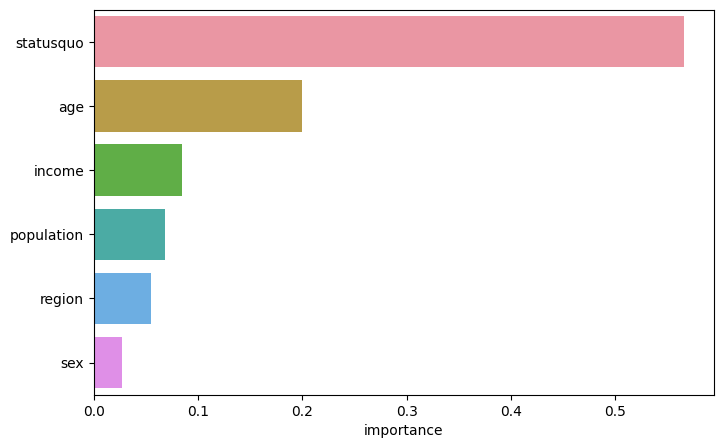

,feature,importance
0,region,0.054709
1,sex,0.026910
2,age,0.199106
3,income,0.084734
4,statusquo,0.566123
5,population,0.068417


In [ ]:
# Create model and fit our training data
rfc = RandomForestClassifier()
rfc.fit(X=X_train, y=y_train.values.ravel())

# Plot feature importance
disp_fi(rfc.feature_names_in_, rfc.feature_importances_)

## XGBClassifier

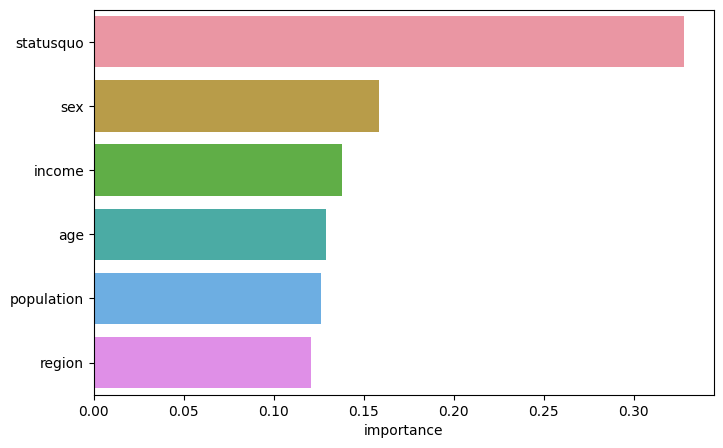

,feature,importance
0,region,0.120466
1,sex,0.158634
2,age,0.128850
3,income,0.137838
4,statusquo,0.328220
5,population,0.125992


In [ ]:
# Create model and fit our training data
xgb_clf = xgb.XGBClassifier(objective='reg:logistic', booster='gbtree')
xgb_clf.fit(X_train, y_train)

# Plot feature importance
disp_fi(xgb_clf.feature_names_in_, xgb_clf.feature_importances_)

## Average Feature Importance

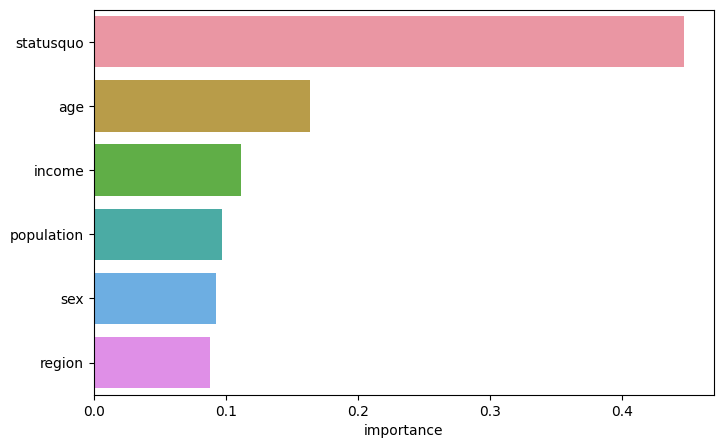

,feature,importance
0,region,0.087588
1,sex,0.092772
2,age,0.163978
3,income,0.111286
4,statusquo,0.447172
5,population,0.097205


In [ ]:
# Calculate average feature importance
avg_fi_value = (xgb_clf.feature_importances_ + rfc.feature_importances_) / 2

# Display average feature importance
disp_fi(xgb_clf.feature_names_in_, avg_fi_value)

We can see that statusquo is the most important feature. Sex is the second and the rest are about equally important at around 10% each.

Since there are differences in the importances between our two models, so we have taken the average importance. The reason for these differences can be explained by the models methodology.

We will focus on statusquo and sex for now.

# Analyze

## Status quo of different voter groups
### Status quo by vote

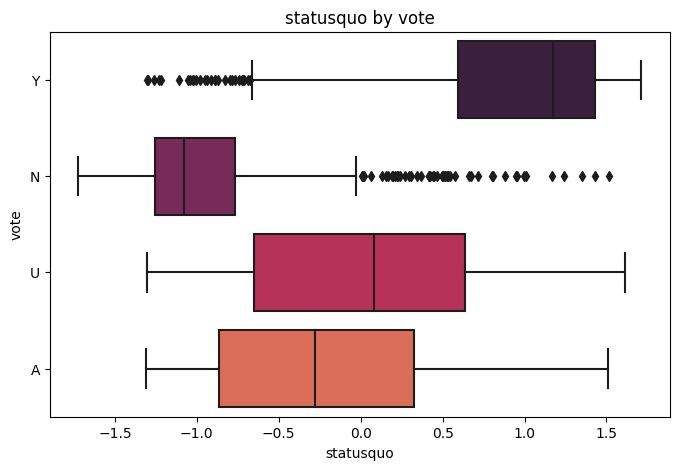

In [ ]:
col2 = df.statusquo
col1 = df.vote

fig = plt.figure(figsize=(8,5))
sns.boxplot(x=col2,y=col1)
plt.title(f'{col2.name} by {col1.name}')
plt.xticks(rotation=0)
plt.show()

We can spot some patterns in the status quo to voting choise:
- Voters with a low status quo generaly vote no
- Voters with a high status quo generaly vote yes
- voters with a status quo value close to 0 are unsure or will abstain

### Status quo by sex

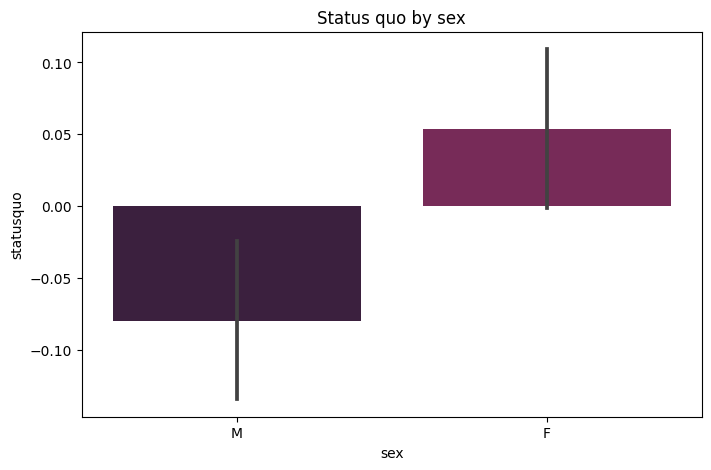

In [ ]:
fig = plt.figure(figsize=(8,5))
sns.barplot(data=df, x="sex", y="statusquo") \
    .set(title='Status quo by sex')
plt.show()

At a first glance we can see a clear pattern of high status quo for women and a low status quo for men. But let's run a quick chi2 test to see if this is an important observation

In [ ]:
test_result = stats.ttest_ind(a=df_enc.sex, b=df_enc.statusquo)
test_result

Ttest_indResult(statistic=21.842426947372623, pvalue=5.726134899362428e-101)

With a p value of 0.28 (28%), we fail to reject the null hypothesis. 

### Region, population and status quo

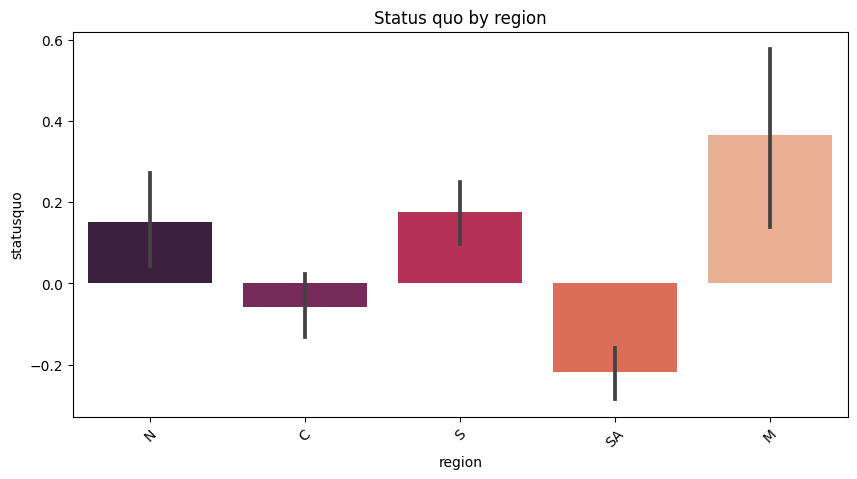

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="region", y="statusquo") \
    .set(title='Status quo by region')
plt.xticks(rotation=45)
plt.show()

We can see a difference of status quo between regions. We'll run a quick test to see if this is an important observation

In [ ]:
pivot = create_anova_frame(df, 'region', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True),
    pivot.iloc[:, 4].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=20.291391494512105, pvalue=1.8557106872735045e-16)

The p value is very low, so we reject the null hypothesis and accept the alternative. This is a statisticaly significant observation

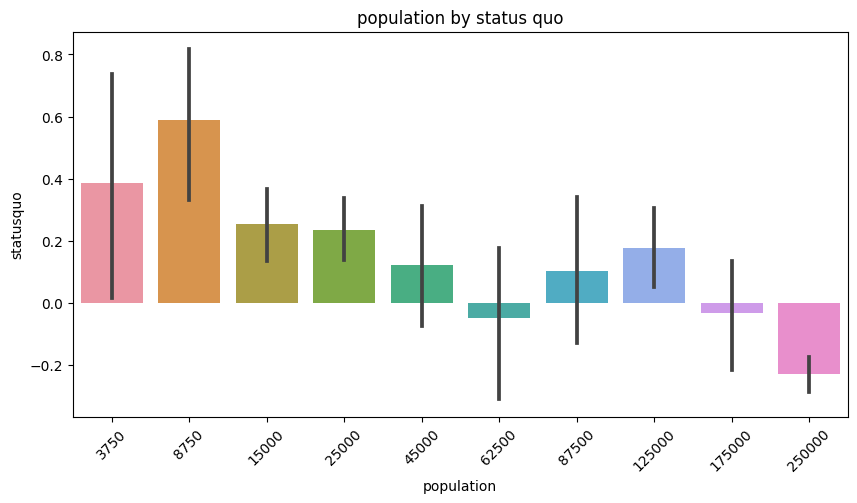

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="population", y="statusquo") \
    .set(title='population by status quo')
plt.xticks(rotation=45)
plt.show()

In [ ]:
pivot = create_anova_frame(df, 'population', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True),
    pivot.iloc[:, 4].dropna().reset_index(drop=True),
    pivot.iloc[:, 5].dropna().reset_index(drop=True),
    pivot.iloc[:, 6].dropna().reset_index(drop=True),
    pivot.iloc[:, 7].dropna().reset_index(drop=True),
    pivot.iloc[:, 8].dropna().reset_index(drop=True),
    pivot.iloc[:, 9].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=14.757748050467878, pvalue=1.509521723254122e-23)

The p value is very low so we reject the null hypothesis and accept the alternative. This is a statisticaly significant observation. Both region and population are statistically significant for the status quo. We can see a trend in the bar plots, the smaller the community, the higher status quo and the opposite for higher populations*

### Income and status quo

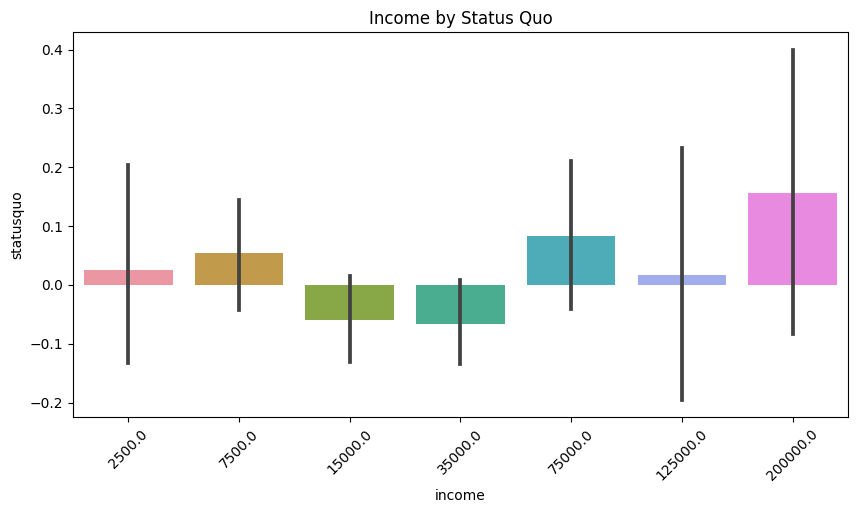

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x="income", y="statusquo") \
    .set(title='Income by Status Quo')
plt.xticks(rotation=45)
plt.show()

In [ ]:
pivot = create_anova_frame(df, 'population', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True),
    pivot.iloc[:, 4].dropna().reset_index(drop=True),
    pivot.iloc[:, 5].dropna().reset_index(drop=True),
    pivot.iloc[:, 6].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=14.053083360537885, pvalue=1.0148553497585403e-15)

### Education status quo

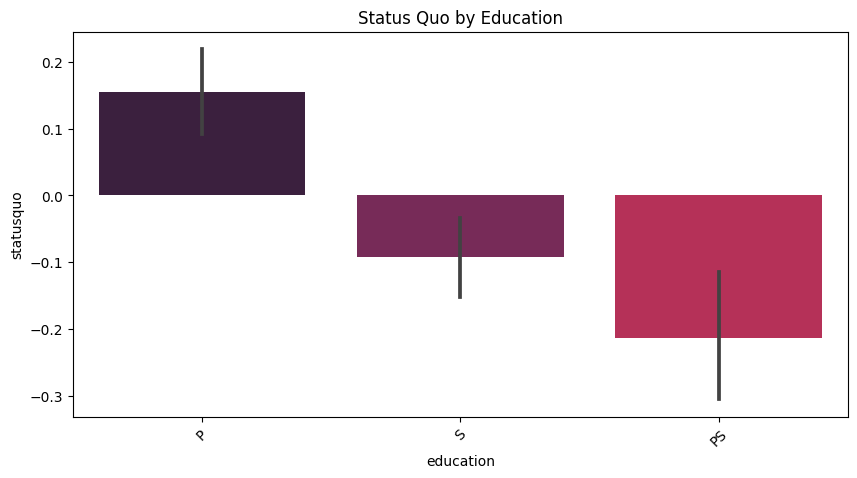

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x=df.education.sort_values(), y="statusquo") \
    .set(title='Status Quo by Education')
plt.xticks(rotation=45)
plt.show()

It looks like there is a difference between education levels and status quo. A Chi2 test will tell us if it is significant 

In [ ]:
pivot = create_anova_frame(df, 'education', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=25.871329135319623, pvalue=7.625566281785641e-12)

We fail to reject the null hypothesis with a p value of 0.58 (58%)

### Age status quo

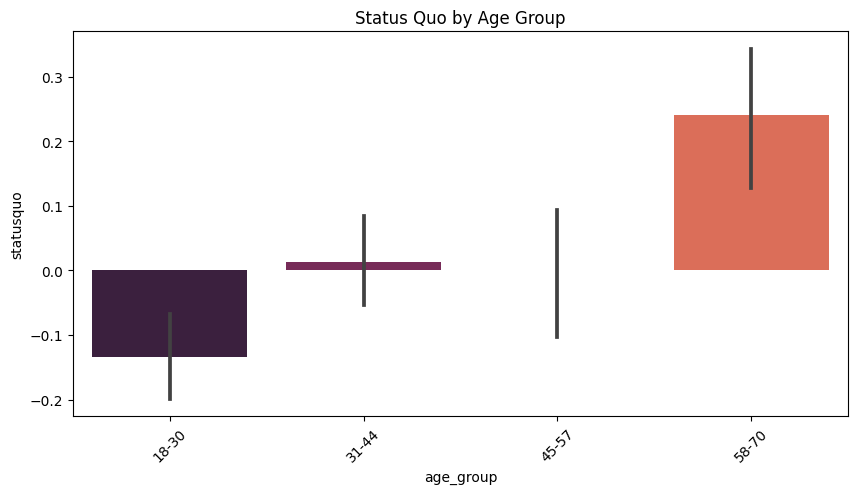

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(data=df, x=df.age_group, y="statusquo") \
    .set(title='Status Quo by Age Group')
plt.xticks(rotation=45)
plt.show()

In [ ]:
pivot = create_anova_frame(df, 'age_group', 'statusquo')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna().reset_index(drop=True),
    pivot.iloc[:, 1].dropna().reset_index(drop=True),
    pivot.iloc[:, 2].dropna().reset_index(drop=True),
    pivot.iloc[:, 3].dropna().reset_index(drop=True))
test_result

F_onewayResult(statistic=12.451725051858485, pvalue=4.429288172316752e-08)

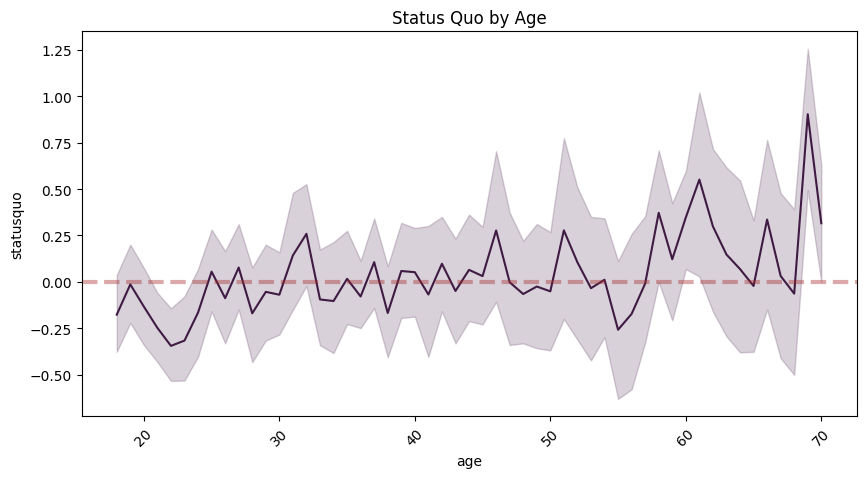

In [ ]:
fig = plt.figure(figsize=(10,5))
ax = sns.lineplot(data=df, x="age", y="statusquo")\
    .set(title='Status Quo by Age')
plt.axhline(linewidth=3, color='brown', alpha=0.4,linestyle='--')
plt.xticks(rotation=45)
plt.show()

In [ ]:
ttest_result = stats.pearsonr(df_enc.age,df_enc.statusquo)
ttest_result

PearsonRResult(statistic=0.111994239607476, pvalue=3.0861029896739633e-08)

## Age
Characteristicts, patterns and relationship between different ages and traits

### Age group vote

<Figure size 800x500 with 0 Axes>

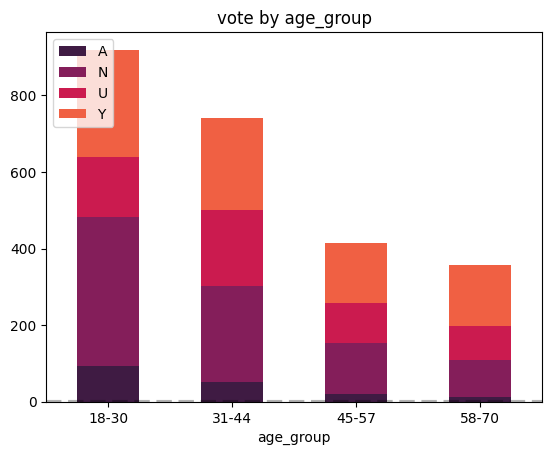

In [ ]:
plot_crosstab(df.age_group, df.vote)

### Age and sex

<Figure size 800x500 with 0 Axes>

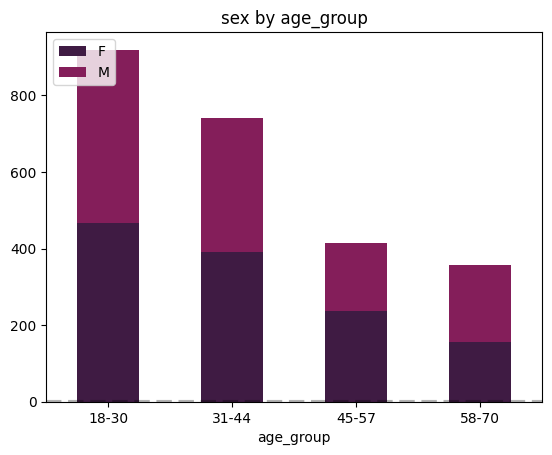

In [ ]:
plot_crosstab(df.age_group, df.sex)

In [ ]:
pd.crosstab(index=df.age_group, columns=df.sex, normalize="index")

sex,F,M
age_group,,
18-30,0.507073,0.492927
31-44,0.529730,0.470270
45-57,0.570048,0.429952
58-70,0.435754,0.564246


In [ ]:
chi_test(df.sex, df.age_group)

(14.889872357728276, 0.0019132204848476384)

It's very even in ages between genders/sexes but there is an imbalance that gives us a p value of ~0.002. So we reject the null hypothesis* 

### Age in different communities

<Figure size 800x500 with 0 Axes>

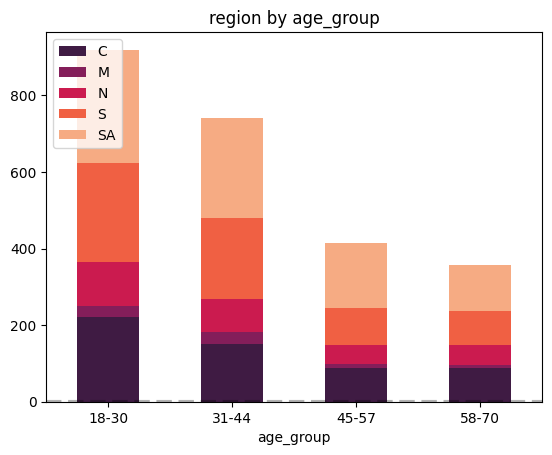

In [ ]:
plot_crosstab(df.age_group, df.region)

In [ ]:
xt = pd.crosstab(df.region, df.age_group)
chi_result = stats.chi2_contingency(xt).pvalue
chi_result

0.10056182355573719

<Figure size 800x500 with 0 Axes>

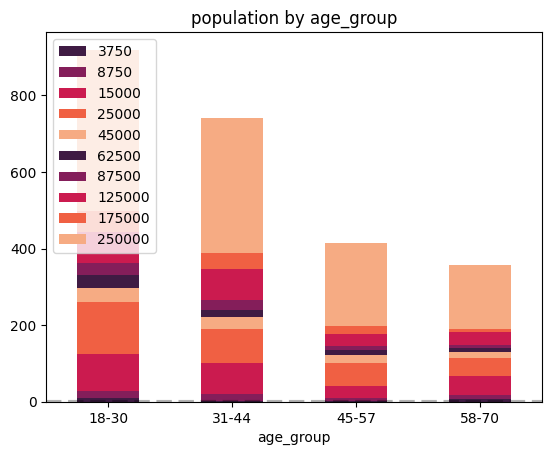

In [ ]:
plot_crosstab(df.age_group, df.population)

In [ ]:
xt = pd.crosstab(df.population, df.age_group)
chi_result = stats.chi2_contingency(xt)
chi_result.statistic, chi_result.pvalue

(34.55575206752542, 0.15048010592922417)

### Age group education

<Figure size 800x500 with 0 Axes>

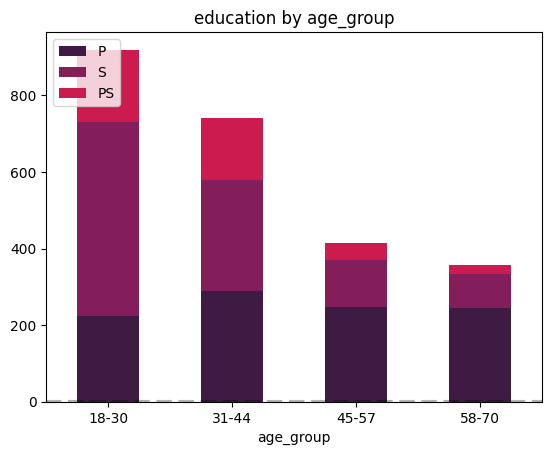

In [ ]:
plot_crosstab(df.age_group, df.education)

In [ ]:
xt = pd.crosstab(df.education, df.age_group)
chi_result = stats.chi2_contingency(xt).pvalue
chi_result

1.0478482364326331e-59

### Age group income

<Figure size 800x500 with 0 Axes>

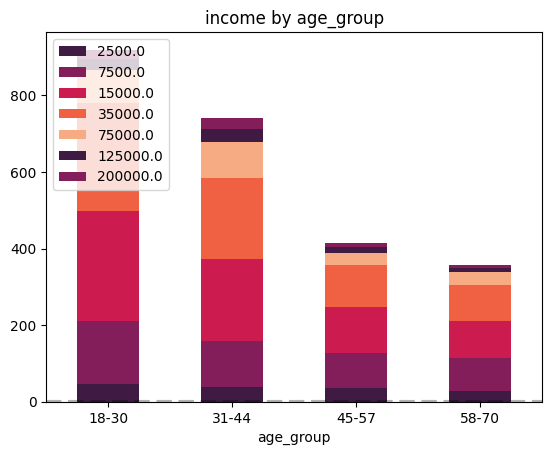

In [ ]:
plot_crosstab(df.age_group, df.income)

In [ ]:
xt = pd.crosstab(df.income, df.age_group)
chi_result = stats.chi2_contingency(xt).pvalue
chi_result

0.005475505898755183

There is a relationship between age and income*

## Ecuation and income

<Figure size 800x500 with 0 Axes>

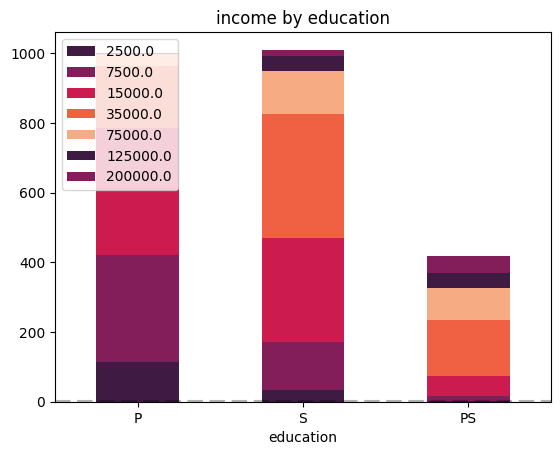

In [ ]:
plot_crosstab(df.education, df.income)

In [ ]:
pivot = create_anova_frame(df, 'education', 'income')

test_result = stats.f_oneway(
    pivot.iloc[:, 0].dropna(),
    pivot.iloc[:, 1].dropna(),
    pivot.iloc[:, 2].dropna())
test_result

F_onewayResult(statistic=314.28130620263005, pvalue=4.1560275391375763e-122)

There is a statistical significant relationship between education and income. We can see that 
- ~80% of voters who didn't continue studying after primary school earn >15000 (P - Primary)
- ~80% of voters who continued studying after secondary school earn >35000 (PS - Post secondary)

# Conclusion * 
Ideally we would get input from someone with more domain knowledge on the subject matter. But we will go as deep as we can for now

## Most important features:
- Status Quo: ~45% importance
- Age : ~ 16.6% importance

## Other features:
The other features were about equal with 10% importance each
- region: ~10%
- sex: ~10%
- income:~10%
- population: ~10%